In [229]:
# Define major financial events/crisis periods
event_periods = [
    #(datetime.datetime(1995, 6, 1), datetime.datetime(1995, 7, 1)),   # Barings Bank collapse
    #(datetime.datetime(1997, 7, 1), datetime.datetime(1998, 6, 1)),   # Asian financial crisis
    #(datetime.datetime(1998, 9, 1), datetime.datetime(1998, 11, 1)),  # Russian financial crisis
    #(datetime.datetime(1999, 3, 1), datetime.datetime(1999, 10, 1)),  # Dot-com bubble (pre-burst)
    #(datetime.datetime(2000, 3, 1), datetime.datetime(2002, 10, 1)),  # Dot-com bubble burst
    #(datetime.datetime(2001, 9, 1), datetime.datetime(2001, 12, 1)),  # September 11 attacks
    #(datetime.datetime(2007, 10, 1), datetime.datetime(2009, 3, 1)),  # Global financial crisis
    #(datetime.datetime(2010, 4, 1), datetime.datetime(2010, 6, 1)),   # Flash crash
    #(datetime.datetime(2011, 8, 1), datetime.datetime(2011, 10, 1)),  # Eurozone debt crisis
    #(datetime.datetime(2013, 5, 1), datetime.datetime(2013, 6, 1)),   # Taper tantrum
    #(datetime.datetime(2015, 8, 1), datetime.datetime(2016, 2, 1)),   # China stock market crash
    (datetime.datetime(2018, 1, 1), datetime.datetime(2018, 4, 1)),   # Cryptocurrency market crash
    (datetime.datetime(2018, 10, 1), datetime.datetime(2019, 1, 1)),  # Stock market turbulence
    (datetime.datetime(2020, 2, 1), datetime.datetime(2020, 6, 1)),    # COVID-19 pandemic
    (datetime.datetime(2022, 1, 1), datetime.datetime(2022, 6, 1)),    # Smaller financial event
    # Add more event periods as needed
]

In [230]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


yf.pdr_override()
#pd.options.display.float_format = '{:.4%}'.format # show table value with 4 digit + %

# Date range
start = '2017-01-01'
end = '2022-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA','SPY']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)['Adj Close']
# Calculating returns
Y = data[assets].pct_change().dropna()

[*********************100%***********************]  26 of 26 completed


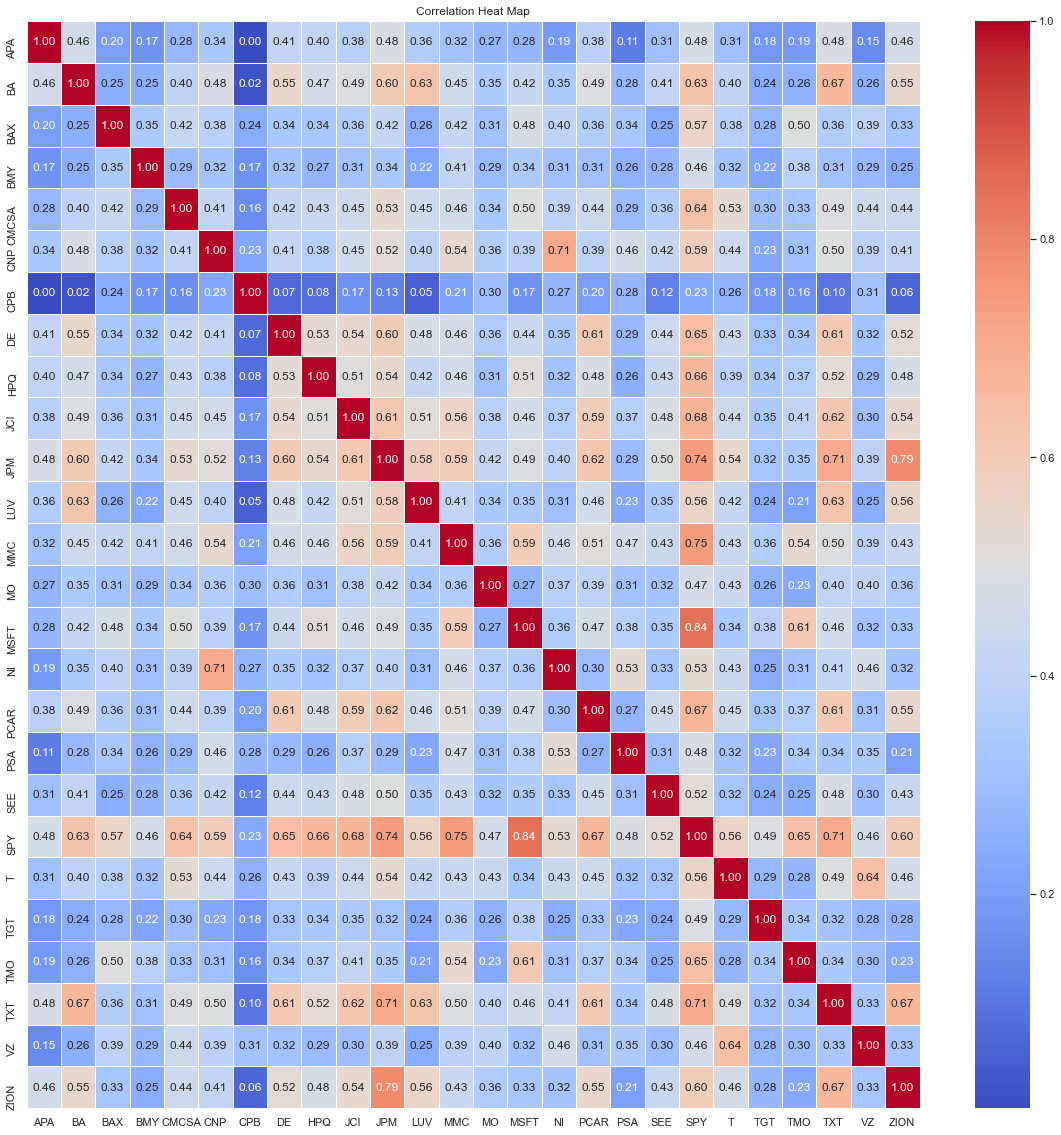

In [231]:
# Plot correlation
correlation_matrix = Y.corr()
sns.set(style="white")
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heat Map")
plt.show()

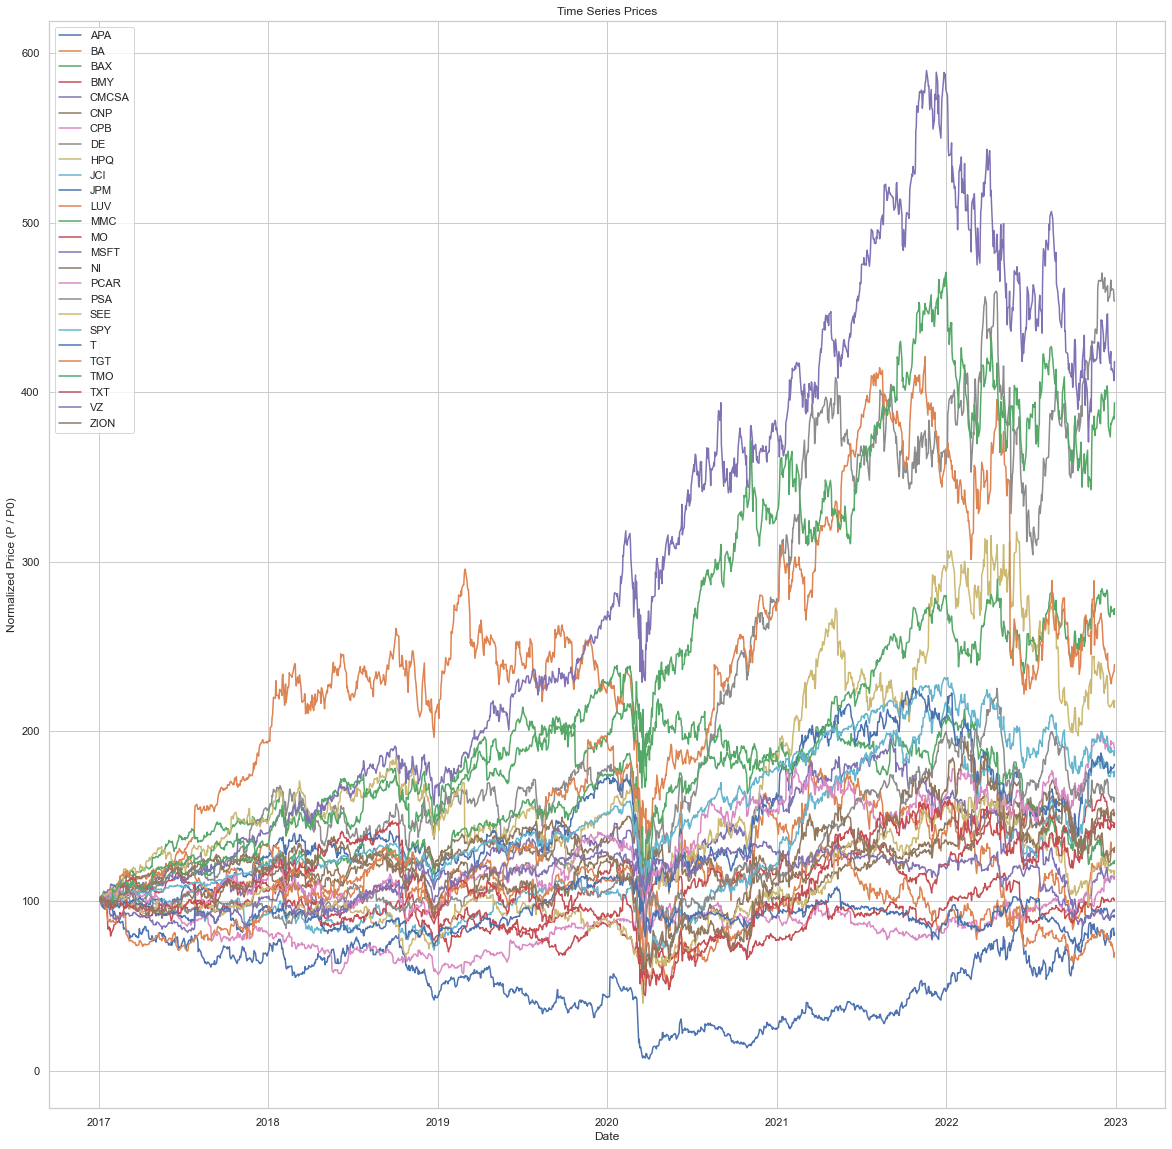

In [232]:
# Plot normalized price
# Normalize prices
sns.set_style('whitegrid')
normalized_prices = (data / data.iloc[0]) * 100

# Plot time series prices
plt.figure(figsize=(20, 20))
for asset in assets:
    plt.plot(normalized_prices.index, normalized_prices[asset], label=asset)

plt.xlabel('Date')
plt.ylabel('Normalized Price (P / P0)')
plt.title('Time Series Prices')
plt.legend()
plt.show()

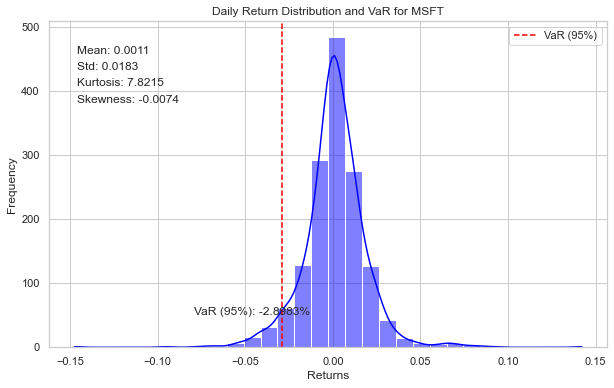

In [233]:
# Calculate returns
price = data[['MSFT']]
returns = Y['MSFT']
benchmark_returns = Y['SPY']

# Calculate Value at Risk (VaR) at 95% confidence level
var_95 = returns.quantile(0.05)

# Calculate kurtosis and skewness
kurtosis = returns.kurtosis()
skewness = returns.skew()
mean = returns.mean()
std = returns.std()

# Plot return distribution and VaR
plt.figure(figsize=(10, 6))
sns.histplot(returns, kde=True, color='blue', bins=30)
plt.axvline(var_95, color='red', linestyle='--', label='VaR (95%)')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Daily Return Distribution and VaR for MSFT')
plt.legend()

plt.annotate(f'VaR (95%): {var_95:.4%}', xy=(var_95, 0), xytext=(var_95 - 0.05, 50))

# Add kurtosis and skewness annotations
plt.text(0.05, 0.9, f'Mean: {mean:.4f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.85, f'Std: {std:.4f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.8, f'Kurtosis: {kurtosis:.4f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.75, f'Skewness: {skewness:.4f}', transform=plt.gca().transAxes)

plt.show()

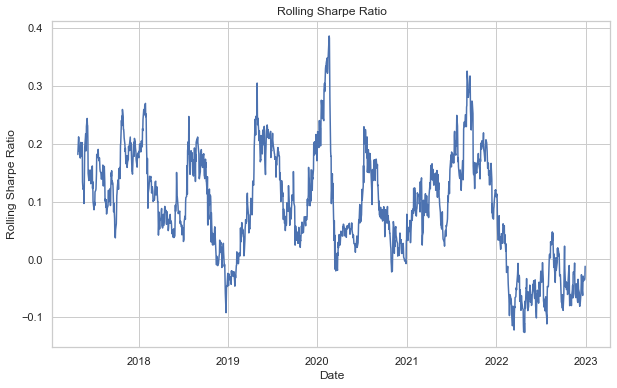

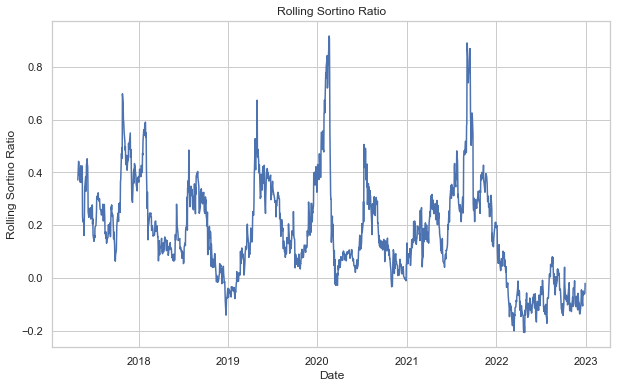

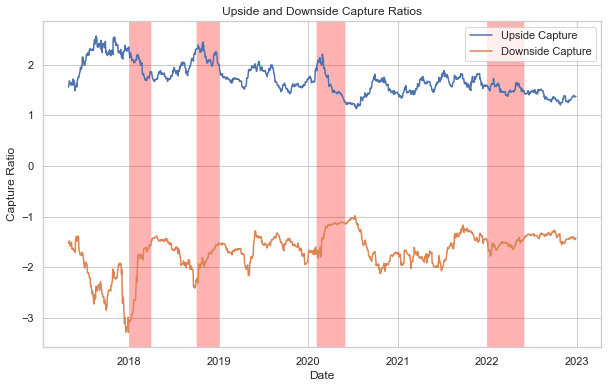

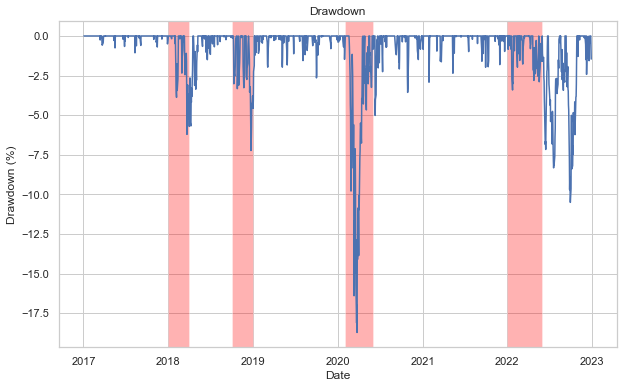

In [257]:
# Calculate rolling statistics
rolling_window = 80  # Number of periods in the rolling window
rolling_sharpe = returns.rolling(window=rolling_window).apply(lambda x: np.mean(x) / np.std(x))
rolling_sortino = returns.rolling(window=rolling_window).apply(lambda x: np.mean(x) / np.std(np.where(x < 0, x, 0)))

rolling_upcapture = returns.rolling(window=rolling_window).apply(lambda x: np.mean(np.where(x > 0, x, 0)))/benchmark_returns.rolling(window=rolling_window).apply(lambda x: np.mean(np.where(x > 0, x, 0)))
rolling_downcapture = returns.rolling(window=rolling_window).apply(lambda x: np.mean(np.where(x < 0, x, 0)))/benchmark_returns.rolling(window=rolling_window).apply(lambda x: np.mean(np.where(x < 0, x, 0)))

drawdown = (1 - (data / data.cummax())).min(axis=1)

# Plot rolling Sharpe ratio
plt.figure(figsize=(10, 6))
plt.plot(rolling_sharpe.index, rolling_sharpe)
plt.xlabel('Date')
plt.ylabel('Rolling Sharpe Ratio')
plt.title('Rolling Sharpe Ratio')
plt.show()

# Plot rolling Sortino ratio
plt.figure(figsize=(10, 6))
plt.plot(rolling_sortino.index, rolling_sortino)
plt.xlabel('Date')
plt.ylabel('Rolling Sortino Ratio')
plt.title('Rolling Sortino Ratio')
plt.show()

# Plot rolling capture ratio
plt.figure(figsize=(10, 6))
plt.plot(rolling_downcapture.index, rolling_upcapture, label='Upside Capture')
plt.plot(rolling_downcapture.index, -rolling_downcapture, label='Downside Capture')
plt.xlabel('Date')
plt.ylabel('Capture Ratio')
plt.title('Upside and Downside Capture Ratios')
plt.legend()
# Add shaded areas for events
for period in event_periods:
    plt.axvspan(period[0], period[1], facecolor='red', alpha=0.3)

# Plot drawdown
plt.figure(figsize=(10, 6))
plt.plot(drawdown.index, -drawdown*100)
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.title('Drawdown')

# Add shaded areas for events
for period in event_periods:
    plt.axvspan(period[0], period[1], facecolor='red', alpha=0.3)
plt.show()

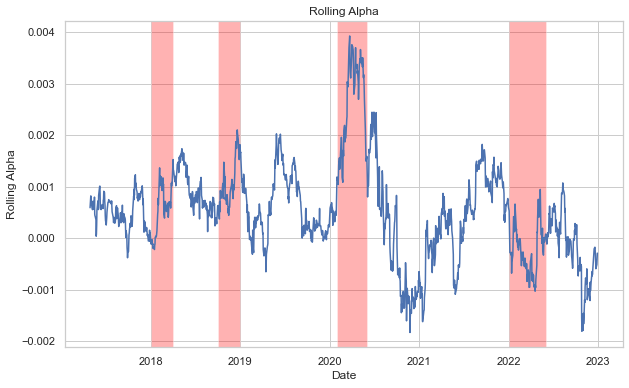

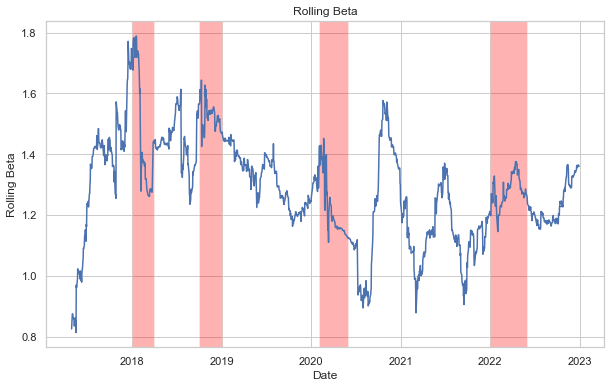

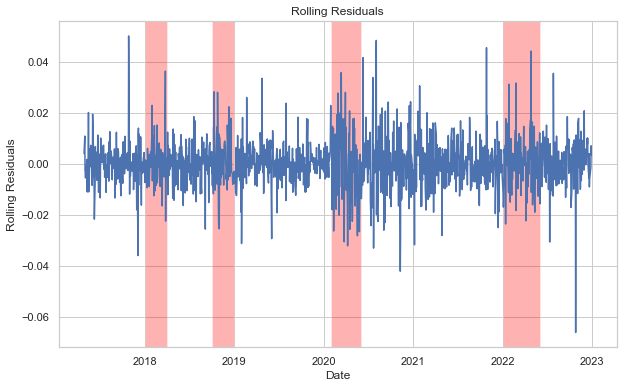

In [235]:
rolling_alpha = pd.Series(index=returns.index)
rolling_beta = pd.Series(index=returns.index)
rolling_residuals = pd.Series(index=returns.index)
rolling_appraisal = pd.Series(index=returns.index)

for i in range(rolling_window, len(returns) + 1):
    rolling_returns = returns.iloc[i - rolling_window:i]
    rolling_benchmark_returns = benchmark_returns.iloc[i - rolling_window:i]

    # Fit a linear polynomial using numpy.polyfit
    coefficients = np.polyfit(rolling_benchmark_returns, rolling_returns, 1)
    alpha = coefficients[1]
    beta = coefficients[0]
    rolling_alpha[rolling_returns.index[-1]] = alpha
    rolling_beta[rolling_returns.index[-1]] = beta
    
    # Calculate the residuals
    rolling_residuals[rolling_returns.index[-1]] = rolling_returns[rolling_returns.index[-1]] - alpha - beta * rolling_benchmark_returns[rolling_returns.index[-1]]
    
    # Calculate Appraisal ratio
    rolling_appraisal[rolling_returns.index[-1]] = alpha / np.std()
    
# Plot rolling alpha
plt.figure(figsize=(10, 6))
plt.plot(rolling_alpha.index, rolling_alpha)
plt.xlabel('Date')
plt.ylabel('Rolling Alpha')
plt.title('Rolling Alpha')

# Add shaded areas for events
for period in event_periods:
    plt.axvspan(period[0], period[1], facecolor='red', alpha=0.3)

plt.show()

# Plot rolling beta
plt.figure(figsize=(10, 6))
plt.plot(rolling_beta.index, rolling_beta)
plt.xlabel('Date')
plt.ylabel('Rolling Beta')
plt.title('Rolling Beta')

# Add shaded areas for events
for period in event_periods:
    plt.axvspan(period[0], period[1], facecolor='red', alpha=0.3)

plt.show()

# Plot rolling residuals
plt.figure(figsize=(10, 6))
plt.plot(rolling_residuals.index, rolling_residuals)
plt.xlabel('Date')
plt.ylabel('Rolling Residuals')
plt.title('Rolling Residuals')

# Add shaded areas for events
for period in event_periods:
    plt.axvspan(period[0], period[1], facecolor='red', alpha=0.3)

plt.show()